In [1]:
# Import used modules
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing
import time

In [2]:
# Define data preprocessing functions
CSV_COLUMN_NAMES = ('time', 'u', 'i')

def _normalize_df(df: pd.DataFrame, normalize: bool) -> None:
    """
    Replace ',' with '.', convert columns to float type
    and normalize to range (0, 1)
    """
    scaler = sklearn.preprocessing.MinMaxScaler((0, 1)) if normalize else None

    for col in df.columns:
        df.loc[:, col] = df.loc[:, col].apply(lambda x: x.replace(',', '.'))
        df.loc[:, col] = df.loc[:, col].astype(np.float64)
        if normalize:
            df.loc[:, col] = scaler.fit_transform(df.loc[:, col].values.reshape(-1, 1))

def load_csv(data_path: str, normalize=True) -> pd.DataFrame:
    df = pd.read_csv(data_path, delimiter=';', names=CSV_COLUMN_NAMES, header=0)
    _normalize_df(df, normalize)
    return df

# Read training data
path = 'data/arrester_data.csv'
df = load_csv(path, normalize=True)

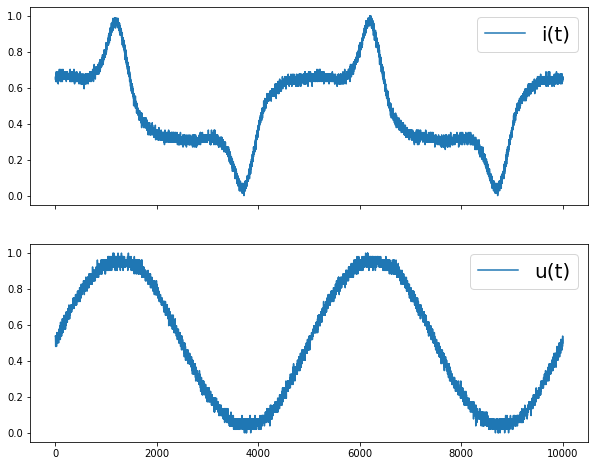

In [3]:
# Plotting training data
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 8))

ax1.plot(df.loc[:, 'i'], label='i(t)')
ax1.legend(loc='upper right', prop={'size': 20})

ax2.plot(df.loc[:, 'u'], label='u(t)')
ax2.legend(loc='upper right', prop={'size': 20})

plt.show()

In [4]:
# Creating training array for recurrent neural network
n_timestamps = 16    # Number of points in single sequence

x = df.loc[:, ['i', 'u']].values  # Converting to numpy array
training_array = []

for i in range(len(x) - n_timestamps):
    training_array.append(x[i:i + n_timestamps])

x_train = np.array(training_array)
y_train = x_train

print(f'Training x shape: {x_train.shape}')
print(f'Training y shape: {y_train.shape}')

Training x shape: (9984, 16, 2)
Training y shape: (9984, 16, 2)


In [5]:
# Converting to tensorflow Datasets
batch_size = 64            # Number of sequences in single data batch
shuffle_buffer_size = 1000 # Number of data points in single shuffle batch 

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.cache().batch(batch_size).shuffle(shuffle_buffer_size).repeat()

In [6]:
# Define LSTM Autoencoder model
from tensorflow.keras import layers


class Encoder(layers.Layer):
    def __init__(self, n_neurons: int, n_timestamps: int, n_features: int):
        super().__init__()
        self._lstm1 = layers.Bidirectional(
            layers.LSTM(units=n_neurons, activation='relu',
                        input_shape=(n_timestamps, n_features),
                        return_sequences=True))
        self._lstm2 = layers.Bidirectional(
            layers.LSTM(units=int(n_neurons / 2), activation='relu',
                        return_sequences=False))

    def call(self, x):
        x = self._lstm1(x)
        return self._lstm2(x)


class Decoder(layers.Layer):
    def __init__(self, n_neurons: int, n_timestamps: int, n_features: int):
        super().__init__()
        self._lstm1 = layers.Bidirectional(
            layers.LSTM(units=int(n_neurons / 2), activation='relu',
                        input_shape=(n_timestamps, n_features),
                        return_sequences=True))
        self._lstm2 = layers.Bidirectional(
            layers.LSTM(units=n_neurons, activation='relu',
                        return_sequences=True))

    def call(self, x):
        x = self._lstm1(x)
        return self._lstm2(x)


class Model(tf.keras.Model):
    def __init__(self, n_neurons: int, n_timestamps: int, n_features: int):
        super().__init__()
        self._encoder = Encoder(n_neurons, n_timestamps, n_features)
        self._decoder = Decoder(n_neurons, n_timestamps, n_features)

        self._repeat_vector = layers.RepeatVector(n_timestamps)
        self._time_distributed = layers.TimeDistributed(
            layers.Dense(n_features))

    def call(self, x):
        x = self._encoder(x)
        x = self._repeat_vector(x)
        x = self._decoder(x)
        return self._time_distributed(x)
    
    def calculate_reconstruction_loss(self, x: np.array) -> np.array:
        y_pred = self.predict(x)
        loss = np.mean((x - y_pred) ** 2, axis=1)
        return np.mean(loss, axis=1)

    def calculate_anomaly_threshold(self, loss: np.array) -> float:
        return loss.max() + (0.25 * loss.std())


In [7]:
# Create model instance
model = Model(n_neurons=64,
              n_timestamps=n_timestamps,
              n_features=x_train.shape[-1])

In [8]:
# Compile model with loss function and optimizer
model.compile(loss='mse', optimizer='adam')

In [9]:
# Train model
steps_per_epoch = x_train.shape[0] // batch_size
model.fit(train_dataset, epochs=10, steps_per_epoch=steps_per_epoch)

Train for 156 steps
Epoch 1/10
156/156 [==============================] - 10s 66ms/step - loss: 0.0342
Epoch 2/10
156/156 [==============================] - 6s 41ms/step - loss: 0.0059
Epoch 3/10
156/156 [==============================] - 6s 41ms/step - loss: 0.0019
Epoch 4/10
156/156 [==============================] - 7s 43ms/step - loss: 0.0010
Epoch 5/10
156/156 [==============================] - 7s 46ms/step - loss: 0.0011
Epoch 6/10
156/156 [==============================] - 7s 44ms/step - loss: 9.9043e-04
Epoch 7/10
156/156 [==============================] - 7s 45ms/step - loss: 0.0028
Epoch 8/10
156/156 [==============================] - 7s 45ms/step - loss: 5.9348e-04
Epoch 9/10
156/156 [==============================] - 7s 46ms/step - loss: 4.0845e-04
Epoch 10/10
156/156 [==============================] - 7s 46ms/step - loss: 7.3431e-04


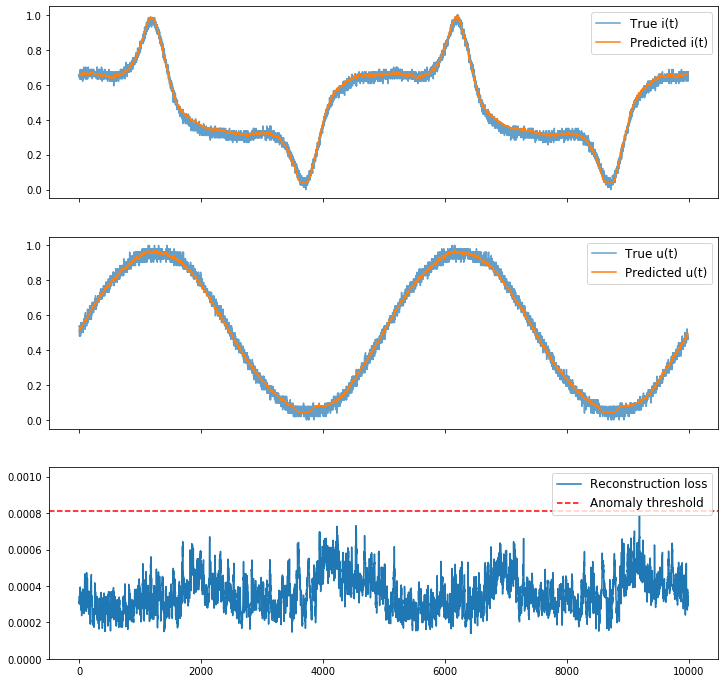

In [10]:
y_pred = model.predict(x_train)

loss = model.calculate_reconstruction_loss(x_train)
anomaly_threshold = model.calculate_anomaly_threshold(loss)

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12, 12))

ax1.plot(x_train[:, 0, 0], label='True i(t)', alpha=0.7)
ax1.plot(y_pred[:, 0, 0], label='Predicted i(t)')
ax1.legend(loc='upper right', prop={'size': 12})

ax2.plot(x_train[:, 0, 1], label='True u(t)', alpha=0.7)
ax2.plot(y_pred[:, 0, 1], label='Predicted u(t)')
ax2.legend(loc='upper right', prop={'size': 12})

ax3.plot(loss, label='Reconstruction loss')
ax3.axhline(y=anomaly_threshold, label='Anomaly threshold', c='r', linestyle='dashed')
ax3.set_ylim([0, anomaly_threshold + (0.3 * anomaly_threshold)])
ax3.legend(loc='upper right', prop={'size': 12})

plt.show()

In [15]:
# Define signal noising function
import random


def add_oscillation(arr: np.array, n: int, perc: float, phase: int) -> None:
    x = np.linspace(phase, (2 * n * np.pi) + phase, arr.shape[0])
    osc_signal = (np.sin(x) * (perc / 100)).reshape(-1, 1)
    arr += osc_signal

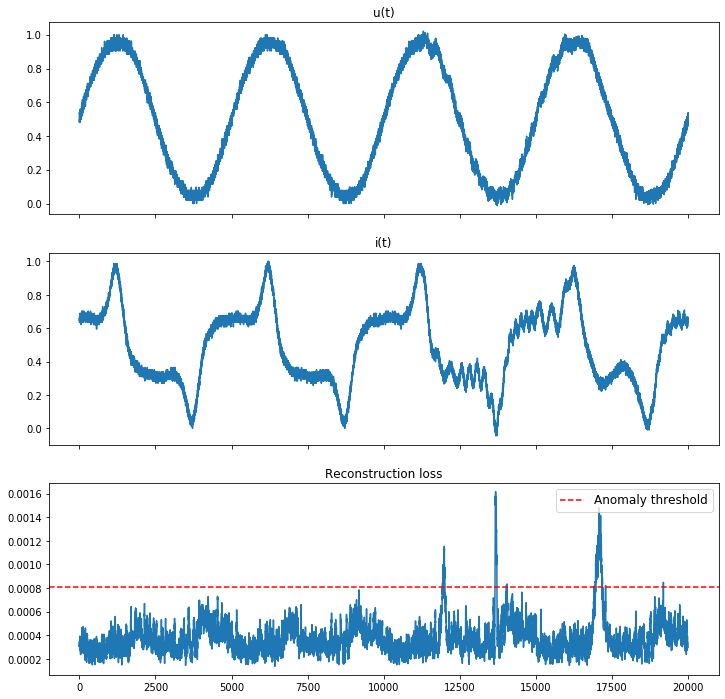

In [35]:
""" Testing on corrupted data """
voltage = np.copy(df.loc[:, 'u'].values.reshape(-1, 1))
current = np.copy(df.loc[:, 'i'].values.reshape(-1, 1))

parts = 8
n_samples_part = int(voltage.shape[0] / parts)

n_harmonics = list(range(8))

u_list = [voltage]
i_list = [current]
for i in range(parts):
    part = i * n_samples_part
    u_signal = np.copy(voltage[part: part + n_samples_part])
    n_harmonic = random.choice(n_harmonics)
    u_harmonic_perc = random.uniform(0.5, 4)
    add_oscillation(u_signal, n_harmonic, u_harmonic_perc, 0)
    u_list.append(u_signal)

    i_signal = np.copy(current[part: part + n_samples_part])
    i_harmonic_perc = random.uniform(1, 8)
    add_oscillation(i_signal, n_harmonic, i_harmonic_perc, phase)
    i_list.append(i_signal)


voltage = np.concatenate(u_list)
current = np.concatenate(i_list)
x_real = np.concatenate((current, voltage), axis=1)

Xs = []
ys = []
for i in range(len(x_real) - n_timestamps):
    Xs.append(x_real[i:i+n_timestamps])

x_real = np.array(Xs)
real_loss = model.calculate_reconstruction_loss(x_real)
#
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12, 12))
ax1.plot(voltage)
ax1.set_title('u(t)')

ax2.plot(current)
ax2.set_title('i(t)')

ax3.plot(real_loss)
ax3.set_title('Reconstruction loss')
ax3.axhline(y=anomaly_threshold, label='Anomaly threshold', c='r', linestyle='--')
ax3.legend(loc='upper right', prop={'size': 12})

plt.show()

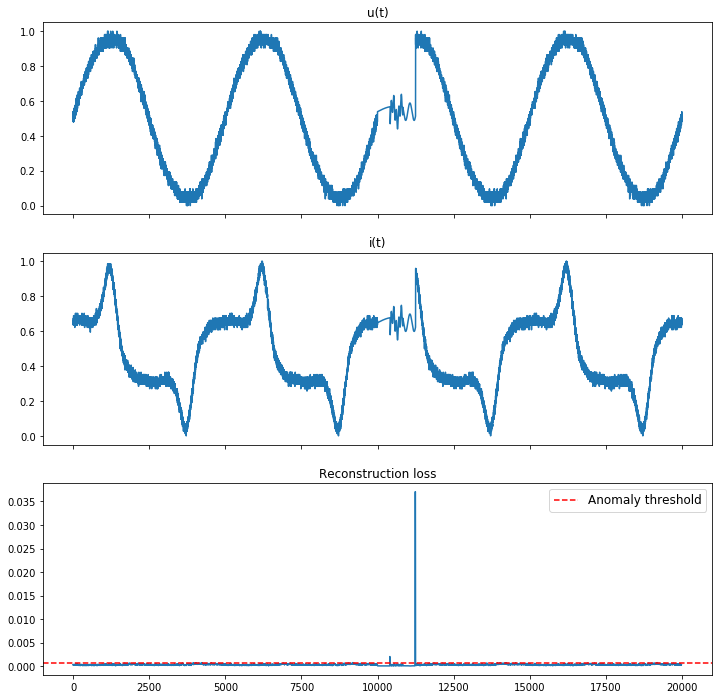

In [137]:
""" Testing on corrupted data """
voltage = np.copy(df.loc[:, 'u'].values.reshape(-1, 1))
current = np.copy(df.loc[:, 'i'].values.reshape(-1, 1))

parts = 8
n_samples_part = int(voltage.shape[0] / parts)

n_harmonics = list(range(8))

u_list = [voltage]
i_list = [current]
for i in range(parts):
    part = i * n_samples_part
    u_signal = np.copy(voltage[part: part + n_samples_part])
    i_signal = np.copy(current[part: part + n_samples_part])

    if i < 1:
        noise_signal_part = int(u_signal.shape[0]/3)
        u_signal = np.full(u_signal.shape, u_signal[0])
        add_oscillation(u_signal[:noise_signal_part], 0.2, 3, 0)
        add_oscillation(u_signal[noise_signal_part:noise_signal_part*2], 5, 5, 200)
        add_oscillation(u_signal[noise_signal_part:], 3, 5, 100)
        
        i_signal = np.full(i_signal.shape, i_signal[0])
        add_oscillation(i_signal[:noise_signal_part], 0.2, 3, 0)
        add_oscillation(i_signal[noise_signal_part:noise_signal_part*2], 5, 5, 200)
        add_oscillation(i_signal[noise_signal_part:], 3, 5, 100)

    u_list.append(u_signal)
    i_list.append(i_signal)


voltage = np.concatenate(u_list)
current = np.concatenate(i_list)
x_real = np.concatenate((current, voltage), axis=1)

Xs = []
ys = []
for i in range(len(x_real) - n_timestamps):
    Xs.append(x_real[i:i+n_timestamps])

x_real = np.array(Xs)
real_loss = model.calculate_reconstruction_loss(x_real)
#
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12, 12))
ax1.plot(voltage)
ax1.set_title('u(t)')

ax2.plot(current)
ax2.set_title('i(t)')

ax3.plot(real_loss)
ax3.set_title('Reconstruction loss')
ax3.axhline(y=anomaly_threshold, label='Anomaly threshold', c='r', linestyle='--')
ax3.legend(loc='upper right', prop={'size': 12})

plt.show()

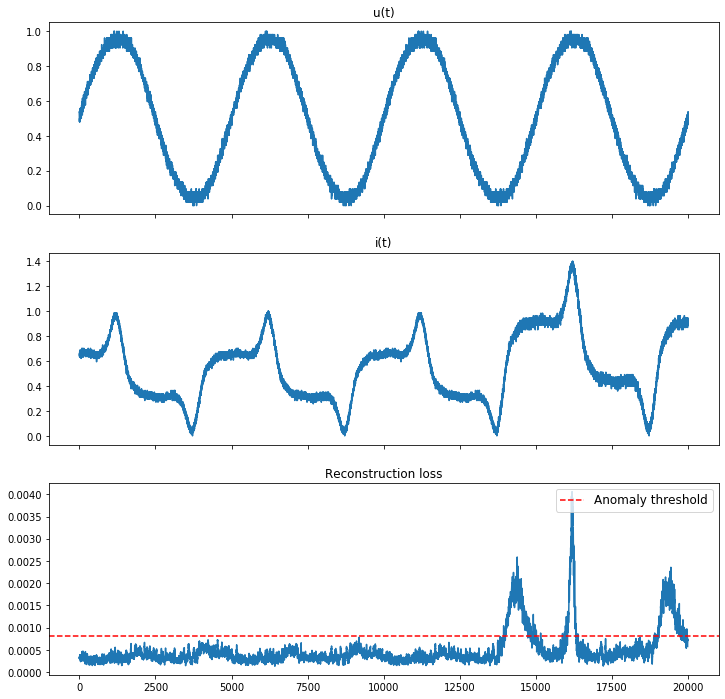

In [101]:
""" Testing on corrupted data """
voltage = np.copy(df.loc[:, 'u'].values.reshape(-1, 1))
current = np.copy(df.loc[:, 'i'].values.reshape(-1, 1))

parts = 8
n_samples_part = int(voltage.shape[0] / parts)

n_harmonics = list(range(8))

u_list = [voltage]
i_list = [current]
for i in range(parts):
    part = i * n_samples_part
    u_signal = np.copy(voltage[part: part + n_samples_part])
    i_signal = np.copy(current[part: part + n_samples_part])

    if i > 2:
        drop_perc = 1.4
        i_signal *= drop_perc

    u_list.append(u_signal)
    i_list.append(i_signal)


voltage = np.concatenate(u_list)
current = np.concatenate(i_list)
x_real = np.concatenate((current, voltage), axis=1)

Xs = []
ys = []
for i in range(len(x_real) - n_timestamps):
    Xs.append(x_real[i:i+n_timestamps])

x_real = np.array(Xs)
real_loss = model.calculate_reconstruction_loss(x_real)
#
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12, 12))
ax1.plot(voltage)
ax1.set_title('u(t)')

ax2.plot(current)
ax2.set_title('i(t)')

ax3.plot(real_loss)
ax3.set_title('Reconstruction loss')
ax3.axhline(y=anomaly_threshold, label='Anomaly threshold', c='r', linestyle='--')
ax3.legend(loc='upper right', prop={'size': 12})

plt.show()

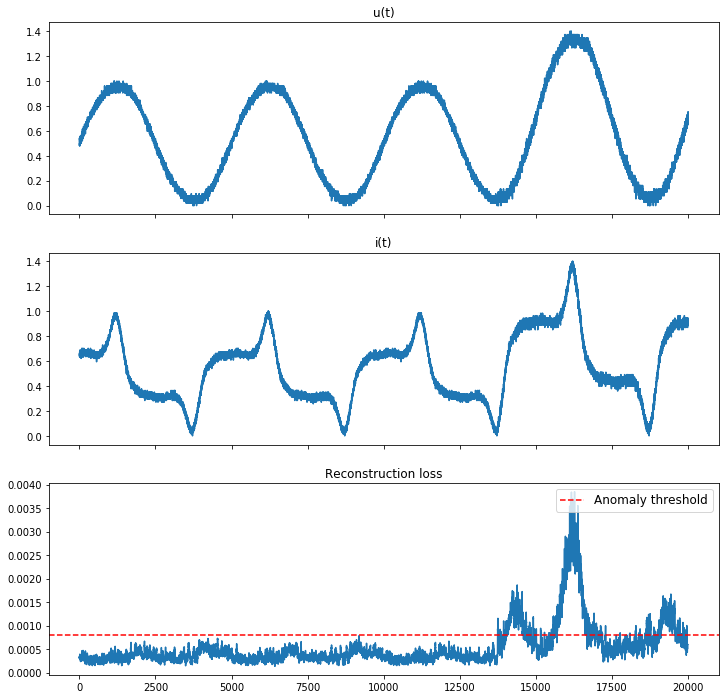

In [139]:
""" Testing on corrupted data """
voltage = np.copy(df.loc[:, 'u'].values.reshape(-1, 1))
current = np.copy(df.loc[:, 'i'].values.reshape(-1, 1))

parts = 8
n_samples_part = int(voltage.shape[0] / parts)

n_harmonics = list(range(8))

u_list = [voltage]
i_list = [current]
for i in range(parts):
    part = i * n_samples_part
    u_signal = np.copy(voltage[part: part + n_samples_part])
    i_signal = np.copy(current[part: part + n_samples_part])

    if i > 2:
        drop_perc = 1.4
        u_signal *= drop_perc
        i_signal *= drop_perc

    u_list.append(u_signal)
    i_list.append(i_signal)


voltage = np.concatenate(u_list)
current = np.concatenate(i_list)
x_real = np.concatenate((current, voltage), axis=1)

Xs = []
ys = []
for i in range(len(x_real) - n_timestamps):
    Xs.append(x_real[i:i+n_timestamps])

x_real = np.array(Xs)
real_loss = model.calculate_reconstruction_loss(x_real)
#
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12, 12))
ax1.plot(voltage)
ax1.set_title('u(t)')

ax2.plot(current)
ax2.set_title('i(t)')

ax3.plot(real_loss)
ax3.set_title('Reconstruction loss')
ax3.axhline(y=anomaly_threshold, label='Anomaly threshold', c='r', linestyle='--')
ax3.legend(loc='upper right', prop={'size': 12})

plt.show()